<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Executive-Summary" data-toc-modified-id="Executive-Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Executive Summary</a></span></li><li><span><a href="#Metric-Goals" data-toc-modified-id="Metric-Goals-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Metric Goals</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Data-schema" data-toc-modified-id="Data-schema-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data schema</a></span></li></ul></li><li><span><a href="#Efficiency-metrics" data-toc-modified-id="Efficiency-metrics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Efficiency metrics</a></span><ul class="toc-item"><li><span><a href="#CTR" data-toc-modified-id="CTR-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CTR</a></span><ul class="toc-item"><li><span><a href="#US-CTR-rankings-(by-mean-values)" data-toc-modified-id="US-CTR-rankings-(by-mean-values)-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>US CTR rankings (by mean values)</a></span></li><li><span><a href="#UK-CTR-rankings-(by-mean-values)" data-toc-modified-id="UK-CTR-rankings-(by-mean-values)-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>UK CTR rankings (by mean values)</a></span></li></ul></li><li><span><a href="#CPC" data-toc-modified-id="CPC-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CPC</a></span><ul class="toc-item"><li><span><a href="#US-CPC-rankings-(by-mean-values)" data-toc-modified-id="US-CPC-rankings-(by-mean-values)-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>US CPC rankings (by mean values)</a></span></li><li><span><a href="#UK-CPC-rankings-(by-mean-values)" data-toc-modified-id="UK-CPC-rankings-(by-mean-values)-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>UK CPC rankings (by mean values)</a></span></li></ul></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#US" data-toc-modified-id="US-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>US</a></span><ul class="toc-item"><li><span><a href="#US-Top-efficient-common-keywords-in-CTR-and-CPC" data-toc-modified-id="US-Top-efficient-common-keywords-in-CTR-and-CPC-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>US Top efficient common keywords in CTR and CPC</a></span></li><li><span><a href="#US-inefficient-common-keywords-in-CTR-and-CPC" data-toc-modified-id="US-inefficient-common-keywords-in-CTR-and-CPC-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>US inefficient common keywords in CTR and CPC</a></span></li><li><span><a href="#US-Visualizations" data-toc-modified-id="US-Visualizations-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>US Visualizations</a></span></li></ul></li><li><span><a href="#UK" data-toc-modified-id="UK-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>UK</a></span><ul class="toc-item"><li><span><a href="#UK-Top-efficient-common-keywords-in-CTR-and-CPC" data-toc-modified-id="UK-Top-efficient-common-keywords-in-CTR-and-CPC-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>UK Top efficient common keywords in CTR and CPC</a></span></li><li><span><a href="#UK-inefficient-common-keywords-in-CTR-and-CPC" data-toc-modified-id="UK-inefficient-common-keywords-in-CTR-and-CPC-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>UK inefficient common keywords in CTR and CPC</a></span></li><li><span><a href="#UK-Visualizations" data-toc-modified-id="UK-Visualizations-5.2.3"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>UK Visualizations</a></span></li></ul></li></ul></li><li><span><a href="#APPENDIX:-General-Trends" data-toc-modified-id="APPENDIX:-General-Trends-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>APPENDIX: General Trends</a></span><ul class="toc-item"><li><span><a href="#US" data-toc-modified-id="US-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>US</a></span></li><li><span><a href="#UK" data-toc-modified-id="UK-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>UK</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
%load_ext watermark

In [2]:
# watermark
%watermark -v -n -m -p numpy -g

Mon Feb 11 2019 

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : 528c56ca2e3b6d1b2dbe3969140e53c72837d720


# Executive Summary 

# Metric Goals

In order to have an efficient ad campaign we prefer high percentage metrics and low cost metrics. Some available metrics include: 

- **Click Through Rate (CTR)** percentage of impressions that turn into clicks 
- **Conversion Rate** percentage of clicks that convert to actions taken
- **Cost per Click (CPC)** total spend divided by total clicks 
- **Cost per Acquisition (CPA)** total spend / total conversions

Given the metrics included in the **Data schema** below, we'll focus on **CTR** and **CPC** metrics for global and regional campaigns. If the table had conversion data, then we could analyze conversions metrics as well. 

# Load Data

## Data schema 
- date : date the data was recorded
- country : country the data was recorded for
- keyword : keyword associated with the campaign
- global_monthly_searches : total monthly searches for that keyword on google globally
- ad_position : how close to the top of the search result page the ad appeared (1 is the top)
- daily_clicks : number of clicks that occurred that day for the keyword
- daily_cost : amount of money spent for the clicks on that keyword on that day
- local_monthly_searches : total monthly searches for that keyword on google for the country
- impressions : number of times the ad was shown to a user that day for that keyword

In [3]:
file_location = 'data/raw/data_challenge.csv'
data = pd.read_csv(file_location, index_col='date')
data.index = pd.to_datetime(data.index)
data.head()

,country,keyword,global_monthly_searches,ad_position,daily_clicks,daily_cost,local_monthly_searches,impressions
date,,,,,,,,
2011-12-25,UK,financial services,4090000.0,1.0,8.0,234.22,246000.0,4757
2011-12-25,UK,certificate of deposit,1830000.0,1.0,148.0,159.49,201000.0,60635
2011-12-25,UK,joint account,201000.0,1.0,1.0,0.20,8100.0,26
2011-12-25,UK,insurance,33100.0,1.0,28.0,490.98,6600.0,34975
2011-12-25,UK,checking account,450000.0,1.0,50.0,133.00,33100.0,16997


# Efficiency metrics

## CTR

In [4]:
# define click thru rate (CTR)
data['CTR'] = data['daily_clicks'] / data['impressions']

### US CTR rankings (by mean values)

In [5]:
region = 'US'


def rank_ctr(data, region):
    df = (data[data['country'] == region]
          .groupby('keyword')[['CTR']]
          .agg('mean')
          .sort_values(by='CTR', ascending=False))
    return df


us_ctr = rank_ctr(data, region)
us_ctr

,CTR
keyword,
banking careers,0.064094
rewards card,0.059658
bankruptcy,0.047311
interest rate,0.046541
debit,0.037072
atm,0.034837
credit cards,0.029102
mortgage,0.026018
lawyer,0.015995


### UK CTR rankings (by mean values)

In [6]:
region = 'UK'
uk_ctr = rank_ctr(data, region)
uk_ctr

,CTR
keyword,
bankruptcy,0.063706
atm,0.052742
credit cards,0.052474
overdraft fee,0.050241
joint account,0.049761
debit,0.048501
interest rate,0.044282
rewards card,0.042312
banking careers,0.037037


## CPC

In [7]:
# define daily CPC, total spend / total clicks 
data['CPC'] = data['daily_cost'] / data['daily_clicks']
# replace inf with None, this handles days with zero clicks
data['CPC'].replace(np.inf, None, inplace=True)

### US CPC rankings (by mean values)

In [8]:
region = 'US'


def rank_cpc(data, region):
    df = (data[(data['country'] == region)]
          .groupby('keyword')[['CPC']]
          .agg('mean')
          .sort_values(by='CPC'))
    return df


us_cpc = rank_cpc(data, region)
us_cpc

,CPC
keyword,
financial services,0.356532
banking careers,0.805990
minimum balance,0.809601
interest rate,0.918934
bankruptcy,1.130540
lawyer,1.364759
rewards card,1.938794
certificate of deposit,3.316022
consolidate loans,3.845810


### UK CPC rankings (by mean values)

In [9]:
region = 'UK'
uk_cpc = rank_cpc(data, region)
uk_cpc

,CPC
keyword,
credit cards,0.367292
debit,0.373333
rewards card,0.522535
banking careers,0.532143
interest rate,0.772643
bankruptcy,0.824024
atm,0.957555
lawyer,1.390875
overdraft fee,1.493898


# Analysis 

## US 

### US Top efficient common keywords in CTR and CPC 
Look at common keywords in top 10 CTR and top 10 CPC

In [10]:
first_index = 0
last_index = 10
region = 'US'


def common_keywords(data, region, first_index=0, last_index=10):
    df_ctr = rank_ctr(data, region)
    df_cpc = rank_cpc(data, region)
    top_ctr = list(df_ctr.index[first_index:last_index])
    top_cpc = list(df_cpc.index[first_index:last_index])
    top = list(set(top_ctr) & set(top_cpc))
    return top


top_us_keywords = common_keywords(data, region, first_index=0, last_index=10)
top_us_keywords

['rewards card',
 'atm',
 'banking careers',
 'interest rate',
 'bankruptcy',
 'lawyer']

### US inefficient common keywords in CTR and CPC
Look at common keywords in bottom 9 CTR and bottom 9 CPC

In [11]:
common_keywords(data, 'US', first_index=11, last_index=19)

['joint account', 'loans', 'wire transfer']

### US Visualizations
Plots CTR and CPC for top 5 keywords with respect to region 

In [12]:
df_us = data[(data['country'] == region)]
df_us_ctr = df_us.pivot_table(columns='keyword', values='CTR', index=df_us.index, fill_value=0)[top_us_keywords]

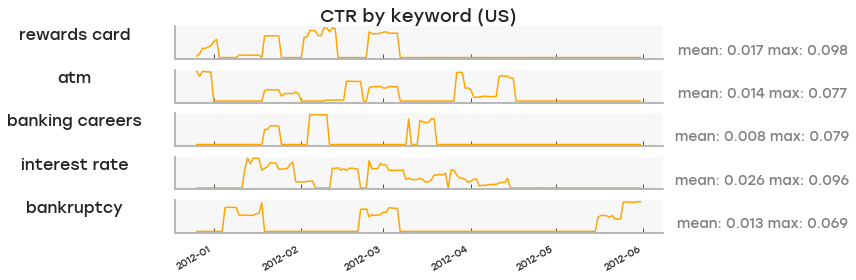

In [13]:
title = 'CTR by keyword (US)'


def spark_plot(df, title):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(
        5, 1, sharex=True, figsize=(12, 4))

    for column, axess in zip(df.columns, (ax1, ax2, ax3, ax4, ax5)):
        df[column].plot(ax=axess, color='orange')
        axess.set_ylabel(str(column), rotation=0, labelpad=100, fontsize=16)
        axess.get_yaxis().set_ticks([])
        axess.set_xlabel('')
        axess.set_facecolor('.97')

        axess2 = axess.twinx()
        local_max = round(df[column].max(), 3)
        local_mean = round(df[column].mean(), 3)
        right_string = 'mean: {local_mean} max: {local_max}'.format(
            local_mean=local_mean,  local_max=local_max)
        axess2.set_ylabel(right_string, rotation=0,
                          labelpad=100, fontsize=14, color='gray')
        axess2.get_yaxis().set_ticks([])

    ax1.set_title(title, fontsize=18)

    fig.tight_layout()
    plt.savefig('reports/figures/'+title + '.pdf')
    return plt.show()


spark_plot(df_us_ctr, title)

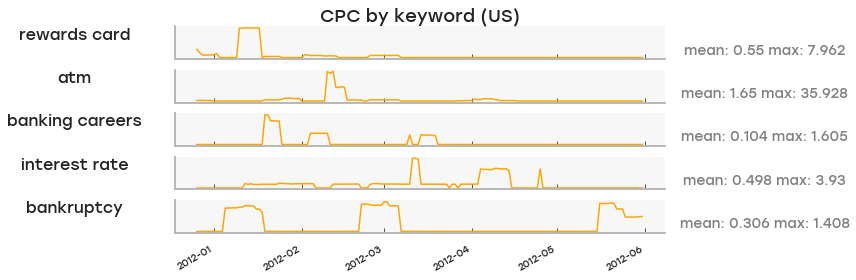

In [14]:
# plot US CPC by keyword 
df_us_cpc = df_us.pivot_table(columns='keyword', values='CPC', index=df_us.index, fill_value=0)[top_us_keywords]
title = 'CPC by keyword (US)'
spark_plot(df_us_cpc, title)

## UK

### UK Top efficient common keywords in CTR and CPC 

In [15]:
region = 'UK'
top_uk_keywords = common_keywords(data, region, first_index=0, last_index=10)
top_uk_keywords

['rewards card',
 'atm',
 'banking careers',
 'interest rate',
 'debit',
 'credit cards',
 'bankruptcy',
 'overdraft fee']

### UK inefficient common keywords in CTR and CPC

In [16]:
common_keywords(data, region, first_index=11, last_index=19)

['minimum balance',
 'insurance',
 'financial services',
 'checking account',
 'loans',
 'consolidate loans']

### UK Visualizations
Plots CTR and CPC for top 5 keywords with respect to region 

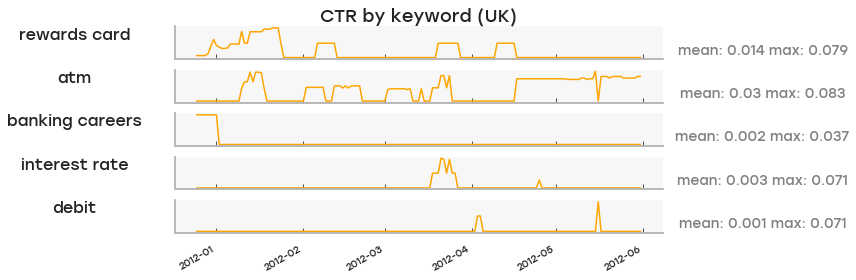

In [17]:
df_uk = data[(data['country'] == region)]
df_uk_ctr = df_uk.pivot_table(columns='keyword', values='CTR', index=df_uk.index, fill_value=0)[top_uk_keywords]
title = 'CTR by keyword (UK)'
spark_plot(df_uk_ctr, title)

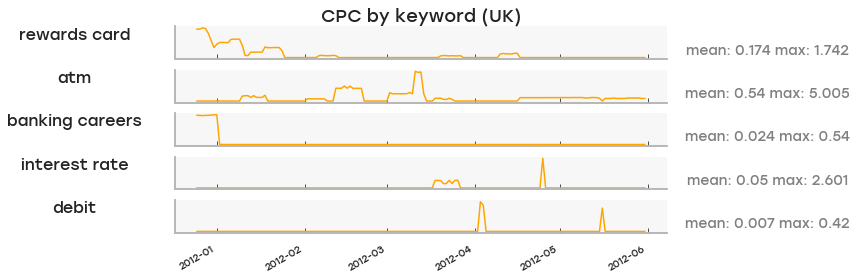

In [18]:
df_uk_cpc = df_uk.pivot_table(columns='keyword', values='CPC', index=df_uk.index, fill_value=0)[top_uk_keywords]
title = 'CPC by keyword (UK)'
spark_plot(df_uk_cpc, title)

# APPENDIX: General Trends

## US

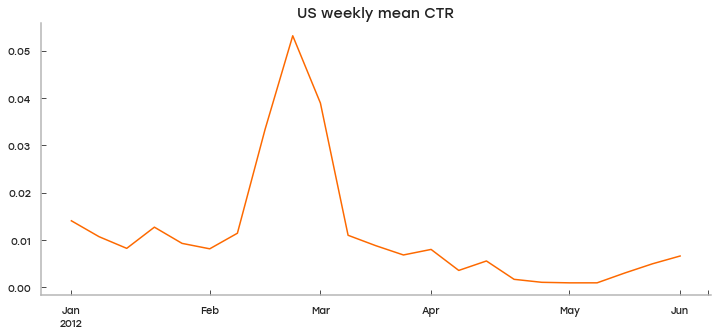

In [19]:
title = 'US weekly mean CTR'
region='US'
data[(data['country']==region)][['CTR']].replace(np.inf,None).resample('W').mean().plot(figsize=(12,5), title=title, legend=False);
plt.xlabel("");

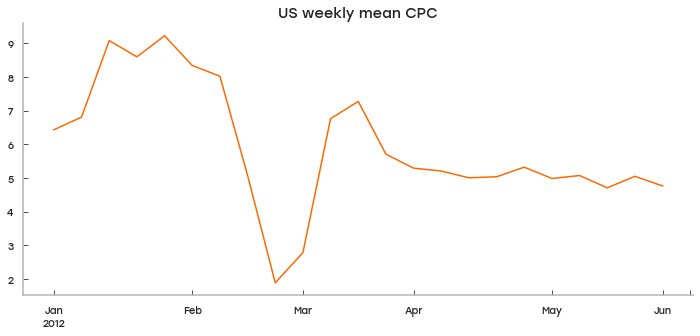

In [20]:
title = 'US weekly mean CPC'
region='US'
data[(data['country']==region)][['CPC']].replace(np.inf,None).resample('W').mean().plot(figsize=(12,5), title=title, legend=False);
plt.xlabel("");

## UK

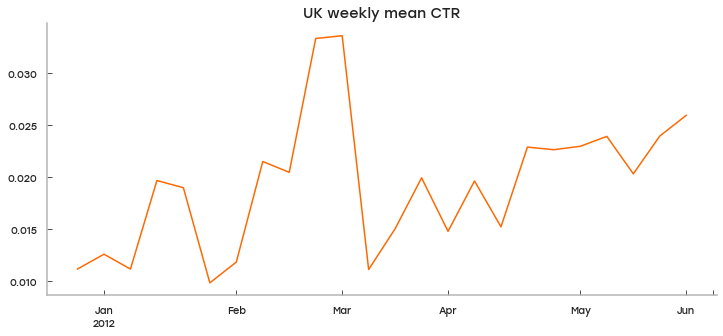

In [21]:
title = 'UK weekly mean CTR'
region='UK'
data[(data['country']==region)][['CTR']].replace(np.inf,None).resample('W').mean().plot(figsize=(12,5), title=title, legend=False);
plt.xlabel("");

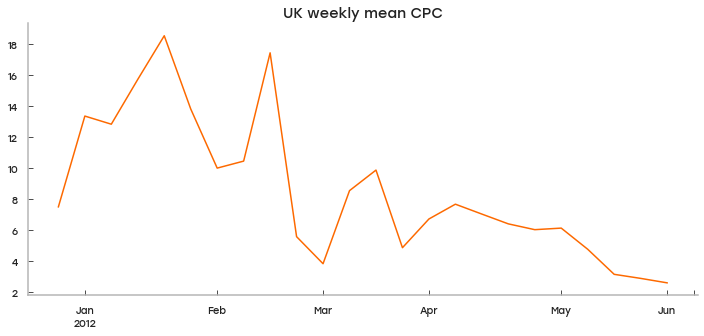

In [22]:
title = 'UK weekly mean CPC'
region='UK'
data[(data['country']==region)][['CPC']].replace(np.inf,None).resample('W').mean().plot(figsize=(12,5), title=title, legend=False);
plt.xlabel("");